In [1]:
# Импорт необходимых библиотек
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Фикс для графиков
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import heapq

from tensorflow import keras
from numpy.core.multiarray import dtype
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Input
from keras.optimizers import RMSprop
from pylab import rcParams
from keras.utils.vis_utils import plot_model
np.random.seed(42)

In [2]:
# Чтение файла

#Загрузим данные
path = 'homer-gnedich.txt'
text = open(path, "r", encoding='utf-8').read().lower()
print ('Длина корпуса: ',len(text))

Длина корпуса:  848472


In [3]:
# Подготовка данных
# Поиск всех уникальных символов в корпусе

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(chars)
print ("Уникальных символов: ",len(chars))

['\n', ' ', '!', '"', '(', ')', ',', '-', '.', '1', '2', '3', '4', '5', '6', '7', '8', ':', ';', '?', 'c', 'e', 'o', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
Уникальных символов:  55


In [4]:
# Разделяем корпус на фрагменты по 39 символов, разделяя последовательности на 3 символа
# Дополнительно сохраним следующий символ (тот, который нам нужно предсказать) для каждой последовательности

SEQUENCE_LENGTH = 39 # длина последовательности
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i:i+SEQUENCE_LENGTH])
    next_chars.append(text[i+SEQUENCE_LENGTH])
print ('Количество обучающих примеров: ',len(sentences))

Количество обучающих примеров:  282811


In [5]:
# Создание объектов и меток.
# Использование ранее сгенерированных последовательностей и символов, которые необходимо предсказать для создания (one-hot encoded vectors) векторов с однократным кодированием 

X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
# Проверка работы функции

sentences[2]

'ев, богиня, воспой ахиллеса, пелеева сы'

In [7]:
# Проверка работы функции

next_chars[2]

'н'

In [8]:
# Проверка работы функции

X[0][0]

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
# Проверка работы функции
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [10]:
X.shape

(282811, 39, 55)

In [11]:
y.shape

(282811, 55)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 39, 128)           94208     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 55)                7095      
                                                                 
Total params: 200,119
Trainable params: 200,119
Non-trainable params: 0
_________________________________________________________________


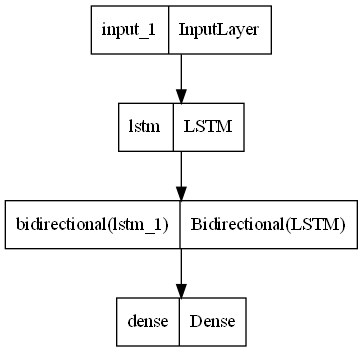

In [12]:
# Графическое представление нашей модели
# Построим модель

model = Sequential()
model.add(Input((SEQUENCE_LENGTH, len(chars))))
model.add(LSTM(units=128, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True, go_backwards=True))
model.add(Bidirectional(LSTM(units=64, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=False, go_backwards=True, recurrent_dropout=0.2)))
model.add(Dense(units=len(chars), activation='softmax'))
model.summary()
keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [13]:
# Обучение модели

optimizer = RMSprop(learning_rate= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X, y, validation_split=0.11, batch_size=256, epochs=10, shuffle=True ).history

Epoch 1/10
984/984 [==============================] - 157s 156ms/step - loss: 2.2433 - accuracy: 0.3348 - val_loss: 2.0444 - val_accuracy: 0.3712
Epoch 2/10
984/984 [==============================] - 159s 161ms/step - loss: 1.8764 - accuracy: 0.4302 - val_loss: 1.8776 - val_accuracy: 0.4298
Epoch 3/10
984/984 [==============================] - 163s 165ms/step - loss: 1.7637 - accuracy: 0.4601 - val_loss: 1.7997 - val_accuracy: 0.4485
Epoch 4/10
984/984 [==============================] - 164s 167ms/step - loss: 1.7035 - accuracy: 0.4757 - val_loss: 1.7593 - val_accuracy: 0.4583
Epoch 5/10
984/984 [==============================] - 159s 162ms/step - loss: 1.6664 - accuracy: 0.4845 - val_loss: 1.7305 - val_accuracy: 0.4701
Epoch 6/10
984/984 [==============================] - 162s 164ms/step - loss: 1.6366 - accuracy: 0.4930 - val_loss: 1.7176 - val_accuracy: 0.4737
Epoch 7/10
984/984 [==============================] - 159s 162ms/step - loss: 1.6162 - accuracy: 0.4980 - val_loss: 1.6897 -

In [14]:
# Сохранение модели

model.save('keras_model'+str(SEQUENCE_LENGTH)+'.h5')
pickle.dump(history, open('history'+str(SEQUENCE_LENGTH)+'.p', 'wb'))

In [15]:
# Загрузка сохраненных весов

model = load_model('keras_model'+str(SEQUENCE_LENGTH)+'.h5')

In [16]:
# Загрузка сохраненной истории

history = pickle.load(open('history'+str(SEQUENCE_LENGTH)+'.p', 'rb'))

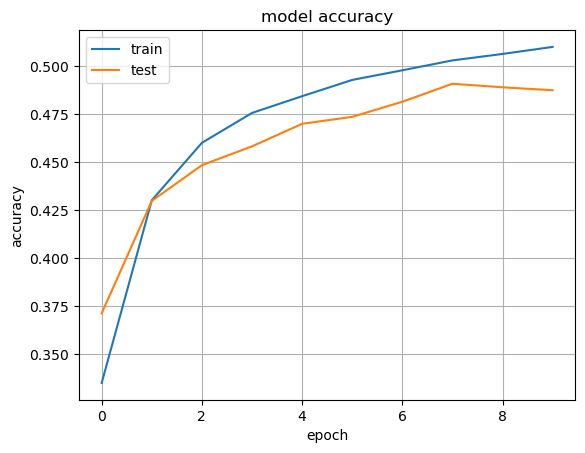

In [17]:
# Оценка и построение графиков
# График правильности модели

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.grid()
plt.savefig("01.Accuracy.png")
plt.show()

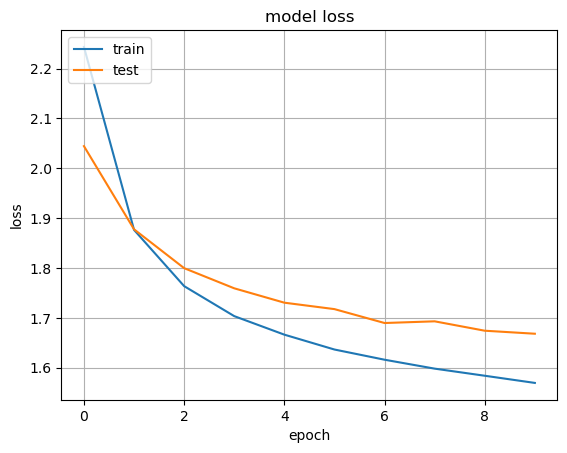

<Figure size 640x480 with 0 Axes>

In [18]:
# График потерь

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.grid()
plt.show()
plt.savefig("02.Loss.png")

In [19]:
# Тестирование

def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x
# Последовательности должны иметь длину 40 символов и тензор формы (1, 40, 55)

In [20]:
# Пример функции
# Эта функция позволяет нам спросить нашу модель, какие следующие вероятные символы

def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [21]:
# Функция прогнозирования

def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char

        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [40]:
# Этот метод оборачивает все и позволяет нам прогнозировать несколько завершений

def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [41]:
quotes = [
    # Примеры из датасета
    "Виду его и величеству: бога, казалось, он видит.", 
    "Так говорил, - и они лошаков и волов подъяремных",
    "В день же десятый, лишь, свет разливая, Денница возникла,",
    "Убран лежит на одре. С восходом Зари возвращаясь,",
    # Примеры не из датасета
    "Предложение - это слово или несколько, связанных между собой по смыслу и выражающих законченную мысль.",
    "Цвели яблони, и пахло медом. Низко груши, да достать легко.",
    "А что? - Да завтра хозяин за сеном едет. Так надо вперед забегать да лаять.",
    "Она предупредила его: В моей стране все переписывается по несколько раз."
]

In [45]:
# Смотрим на предсказания (совпадут ли они с нашими предложениями?)

for q in quotes:
    seq = q[:SEQUENCE_LENGTH].lower()
    print (seq)
    print (predict_completions(seq, 5))
    print ()

виду его и величеству: бога, казалось, 
['и ', 'которые ', 'подвигнулось ', 'с ', 'на ']

так говорил, - и они лошаков и волов по
['лотив ', 'разил ', 'добный ', 'стигнулось ', 'ток ']

в день же десятый, лишь, свет разливая,
[' с ', '\n ', '-\n ', 'и ', 'а ']

убран лежит на одре. с восходом зари во
['скликнули ', 'звратился ', 'противный ', 'лным ', 'инствовал ']

предложение - это слово или несколько, 
['страшных ', 'и ', 'подвигнулось ', 'возвратился ', 'который ']

цвели яблони, и пахло медом. низко груш
['ительный ', 'у ', 'ени ', 'ал ', 'ный ']

а что? - да завтра хозяин за сеном едет
[' и ', '.\n ', ';\n ', ', ', '\n ']

она предупредила его: в моей стране все
[' подвигнулось ', 'м ', 'х ', 'гда ', 'ю ']

